# Graph Cut Segmentation

In this part you will implement foreground-background segmentation using *Markov random fields* (MRF).

## Recap from the lecture
A Markov random field is a graphical model that expresses the structure of (input and output) variables. In our case that means we do not only use a color model for foreground and background but also take into account the neighborhood relations of the pixels. This encodes the intuition that neighboring pixels usually belong to the same region.

The color (or more generally, appearance) models and the neighborhood relations are combined in a so-called *energy function* (or cost function), which is then minimized to obtain an optimal label-assignment.

Given a structured input (here: image pixel colors) $\mathcal{Y} = \{Y_j|j \in I\}$ we want to find the output (here: labeling) $\mathcal{X} = \{X_j | j \in I\}$ such that

$$
\hat{\mathcal{X}} = \arg \min_{\mathcal{X}} E(\mathcal{X}, \mathcal{Y})
$$

$$
E(\mathcal{X}, \mathcal{Y}) = \sum_{j\in I}{\psi_u (X_j,Y_j)} + \sum_{i, j\in I}{\psi_p (X_j,X_j,Y_i,Y_j, i, j)}.
$$

The set $I$ contains all possible pixel indices. In our two-label (binary) segmentation case, the label variables must be either 0 (background) or 1 (foreground) $X_j \in \{0, 1\}$.

The so-called *unary potential* $\psi_u (X_j,Y_j)$ is the cost of assigning the label $X_j$ to a pixel with color $Y_j$. In probabilistic terms, the unary potential is

$$
\psi_u (X_j,Y_j)=-\omega_u \cdot \log p(X_j|Y_j),
$$

with an appropriate model $p$ for the foreground and the background and a weighting factor $\omega_u$. The unaries encourage labeling each pixel with the label (foreground/background) whose color model is a better fit for that particular pixel.

The *pairwise potential* $\psi_p$ incorporates the dependencies between pixels. To speed up the computation, the pairwise model is usually restricted to neighboring pixels and is therefore set to zero if the $i$th and $j$th pixels are not direct neighbors in a 4-neighborhood. In our case it written as:

$$
\psi_p (X_i,X_j,Y_i,Y_j, i, j)=\omega_p\cdot
\begin{cases}
1,&\text{if }   X_i\neq X_j \text{ and } i,j \text{ are neighbors}  \\
0,&\text{otherwise}
\end{cases}
$$

with some weighting factor $\omega_p$. Such pairwise potentials encourage neighboring pixels to have the same label.

A Graph Cut method is used to find the optimal solution $\hat{\chi}$ of the energy function.

## Bird's eye overview

It's easy to get lost in all the details, so here's an roadmap of what we're going to do:

1. Set up the Markov Random Field (define unaries and pairwise potentials), in more detail:
    1. Model the distribution of background and foreground colors based on the colors found in approximate initial regions
    2. For each pixel independently, calculate the posterior probability of being foreground, based on the models from the previous step ("probability map")
    3. Calculate the unary potentials based on the foreground probability map
    4. Define the pairwise potentials (using the neighborhood relations)
2. Use graph cuts to minimize the energy function of the Markov Random Field and obtain a labeling

You will not have to implement the min-cut algorithm yourself, we will use the `pygco` ("Python Graph Cut Optimizer") package for that. You can install it using `conda install pygco -c kayarre`. (This is a Python wrapper over the C++ gco library, which can be found at https://vision.cs.uwaterloo.ca/code/)

In [2]:
%%html
<!-- Add heading numbers -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section) " ";}
</style>

In [3]:
# Some imports and helper functions
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import imageio
import time
import cv2
import pygco  # conda install pygco -c kayarre

def draw_mask_on_image(image, mask, color=(0, 255, 255)):
    """Return a visualization of a mask overlaid on an image."""
    result = image.copy()
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_DILATE, kernel)
    outline = dilated > mask
    result[mask == 1] = (result[mask == 1] * 0.4 + 
                         np.array(color) * 0.6).astype(np.uint8)
    result[outline] = color
    return result

## Initial masks

First, manually create initial boxes of foreground and background regions.

We will use these to build color models. That is, to model the probability of a pixel color occuring, given either that it is a foreground or a background pixel.

<IPython.core.display.Javascript object>


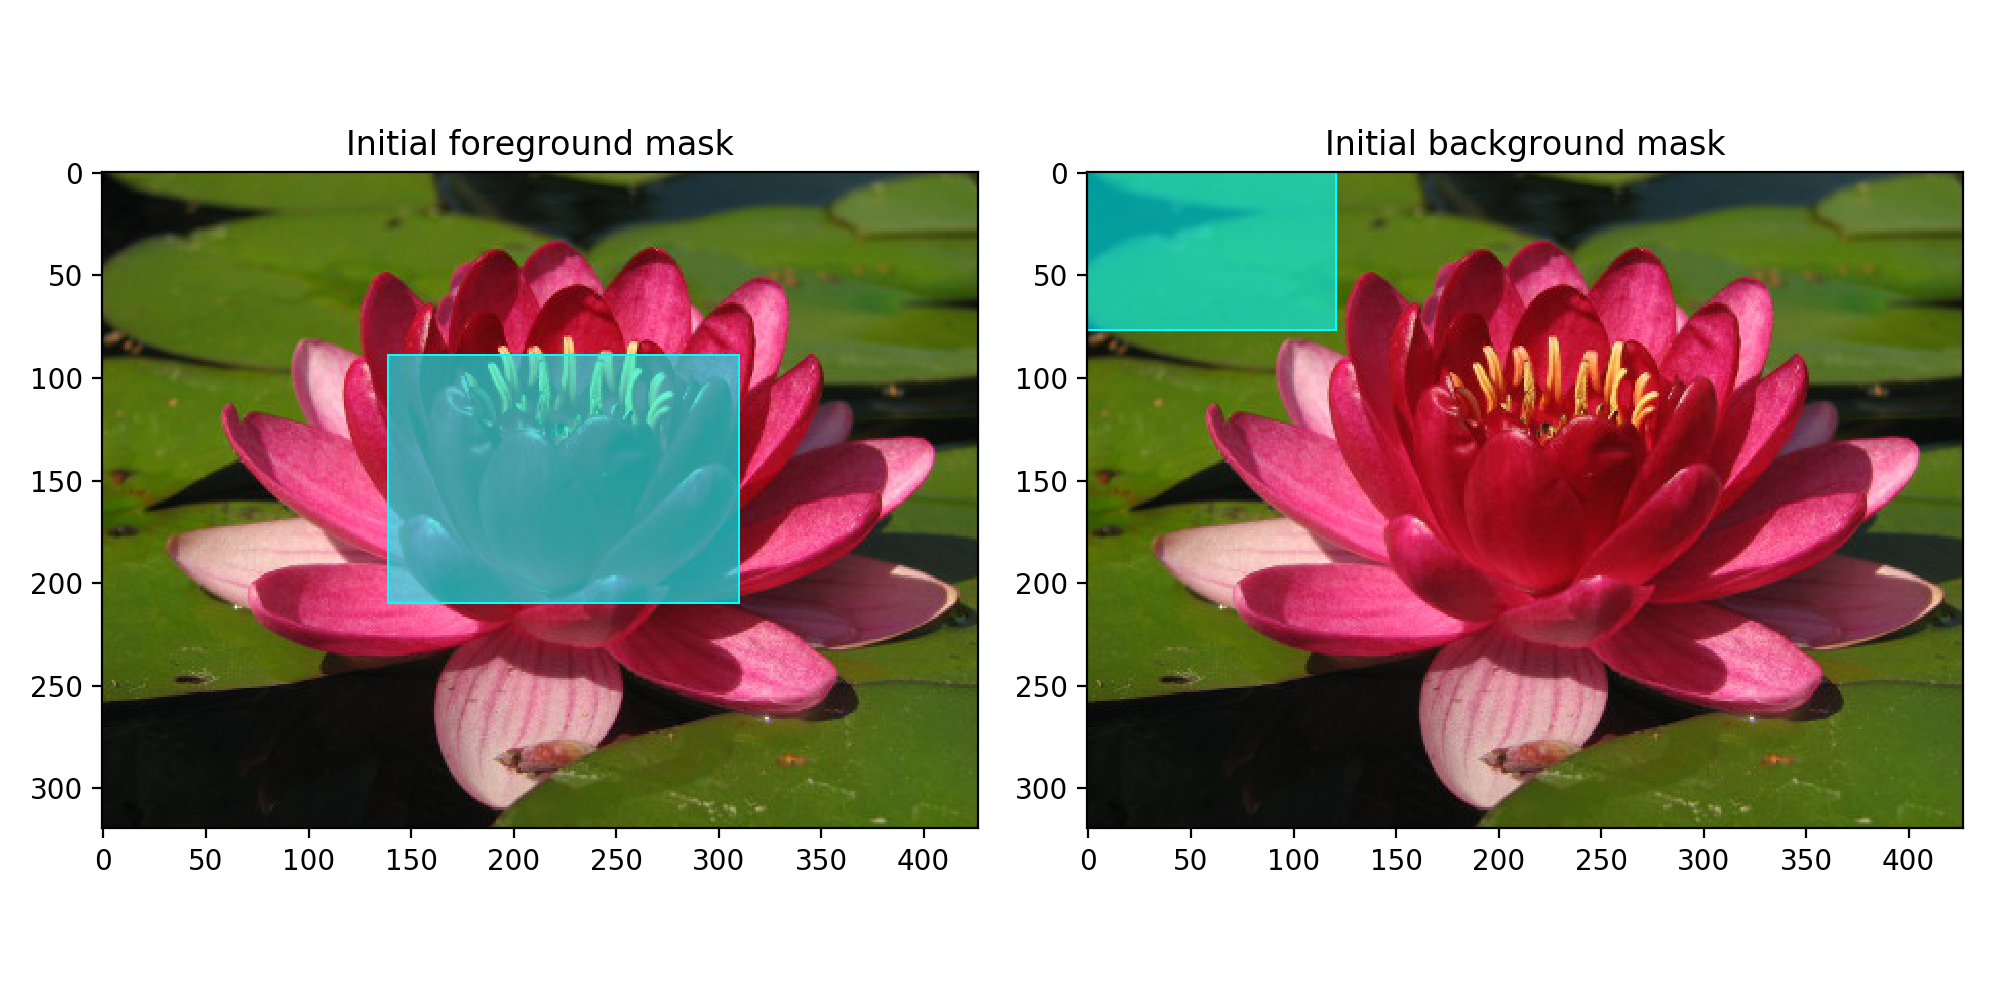

In [4]:
im = imageio.imread('lotus320.jpg')
h,w = im.shape[:2]

# Set up initial foreground and background
# regions for building the color model
init_fg_mask = np.zeros([h, w])
init_bg_mask = np.zeros([h, w])

# Do something like the following but with sensible
# indices
#init_fg_mask[10:20, 15:30] = 1
#init_bg_mask[60:90, 50:110] = 1

### BEGIN SOLUTION
init_fg_mask[90:210, 140:310] = 1
init_bg_mask[0:77, 0:121] = 1
### END SOLUTION

fig, axes = plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('Initial foreground mask')
axes[0].imshow(draw_mask_on_image(im, init_fg_mask))
axes[1].set_title('Initial background mask')
axes[1].imshow(draw_mask_on_image(im, init_bg_mask))
fig.tight_layout()

## Color histograms

Usually *Gaussian mixture models* are used to model color distributions. However, to keep this exercise simple, we will only use color histograms (i.e. the relative frequencies of quantized colors) in the respective region of the image defined by the boxes. In other words, we model the color simply as a categorical random variable.

Implement the function `calculate_histogram`. It should take as input the image `img` with values in $[0, 255]$ and a `mask` the same size as the image. The mask is 1 at the positions of the image where the histogram should be computed, zero otherwise. The final parameter `n_bins` defines how many bins should be used in the histogram in each dimension. The function should **return a 3-dimensional array** of shape `[n_bins, n_bins, n_bins]`, containing the relative frequency for each (r,g,b) color bin within the region of the image defined by the mask, i.e. the fraction of pixels falling within each bin. The histogram should be normalized (sum to 1). Initialize all bins with a small value ($10^{−3}$) to counteract relative frequencies which are zero (this method is called additive smoothing).

In [5]:
def calculate_histogram(img, mask, n_bins):
    histogram = np.full((n_bins, n_bins, n_bins), fill_value=0.001)
    
    ### BEGIN SOLUTION
    # convert values to range of bins
    binned_im = (img.astype(np.float32)/256*n_bins).astype(int)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            if mask[y, x] != 0:
                histogram[binned_im[y, x, 0],
                          binned_im[y, x, 1], 
                          binned_im[y, x, 2]] += 1
                
    # normalize
    histogram /= np.sum(histogram)
    
    ### END SOLUTION
    return histogram

<IPython.core.display.Javascript object>


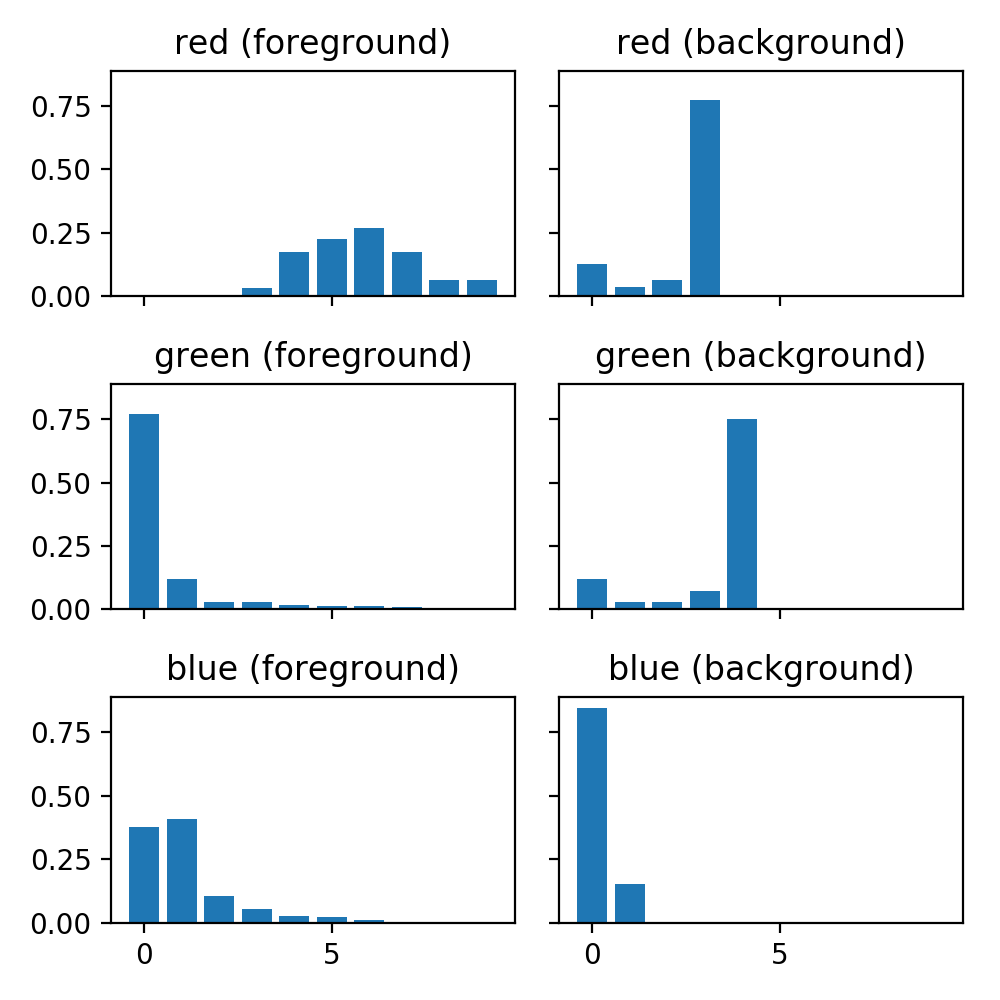

In [6]:
n_bins = 10
fg_histogram = calculate_histogram(im, init_fg_mask, n_bins)
bg_histogram = calculate_histogram(im, init_bg_mask, n_bins)

fig, axes = plt.subplots(
    3, 2, figsize=(5,5), sharex=True, 
    sharey=True, num='Relative frequency of color bins')

x = np.arange(n_bins)
axes[0,0].bar(x, np.sum(fg_histogram, (1, 2)))
axes[0,0].set_title('red (foreground)')
axes[1,0].bar(x, np.sum(fg_histogram, (0, 2)))
axes[1,0].set_title('green (foreground)')
axes[2,0].bar(x, np.sum(fg_histogram, (0, 1)))
axes[2,0].set_title('blue (foreground)')

axes[0,1].bar(x, np.sum(bg_histogram, (1, 2)))
axes[0,1].set_title('red (background)')
axes[1,1].bar(x, np.sum(bg_histogram, (0, 2)))
axes[1,1].set_title('green (background)')
axes[2,1].bar(x, np.sum(bg_histogram, (0, 1)))
axes[2,1].set_title('blue (background)')
fig.tight_layout()

What do you see in these histograms?

## Foreground probability map

The next step in the segmentation process is to estimate a probability map: For each pixel we want to estimate the probability that it belongs to the foreground. This will be used as basis for the unary potential.

The function `foreground_pmap(img, fg_histogram, bg_histogram)` should take the image `img` and the two histograms `fg_histogram`, `bg_histogram` estimated from the foreground region and the background region respecively. It should return an array of shape $\texttt{height}\times\texttt{width}$ containing the probability of each pixel belonging to the foreground. To estimate the required probability $p(c|[r, g, b])$ from the computed histograms, a class prior $p(c)$ of $0.5$ should be used, which means that both foreground and background pixels are equally likely a priori. 

Recall Bayes' theorem applied to this case:

$$
p(c\ |\ r,g,b) = \frac{p(c) \cdot p(r,g,b\ |\ c)}{p(r,g,b)} = \frac{p(c)\cdot p(r,g,b\ |\ c)}{\sum_{\tilde{c}} p(\tilde{c}) \cdot p(r,g,b\ |\ \tilde{c}) }
$$

In [7]:
def foreground_pmap(img, fg_histogram, bg_histogram):
    ### BEGIN SOLUTION
    h, w, c = img.shape
    n_bins = len(fg_histogram)
    binned_im = (img.astype(np.float32)/256*n_bins).astype(int)
    
    # prior probabilities
    p_fg = 0.5
    p_bg = 1 - p_fg
    
    # extract fg & bg prob from histograms
    p_rgb_given_fg = fg_histogram[binned_im[:, :, 0],
                                  binned_im[:, :, 1], 
                                  binned_im[:, :, 2]]
    
    p_rgb_given_bg = bg_histogram[binned_im[:, :, 0],
                                  binned_im[:, :, 1],
                                  binned_im[:, :, 2]]
    
    p_fg_given_rgb = (p_fg * p_rgb_given_fg /
                      (p_fg * p_rgb_given_fg + p_bg * p_rgb_given_bg))
    return p_fg_given_rgb
    ### END SOLUTION
    
def likelihood_map(img, histogram):
    ### BEGIN SOLUTION
    h, w, c = img.shape
    n_bins = len(histogram)
    binned_im = (img.astype(np.float32)/256*n_bins).astype(int)
    
   
    # extract fg & bg prob from histograms
    return histogram[binned_im[:, :, 0],
                       binned_im[:, :, 1], 
                       binned_im[:, :, 2]]
    ### END SOLUTION


<IPython.core.display.Javascript object>


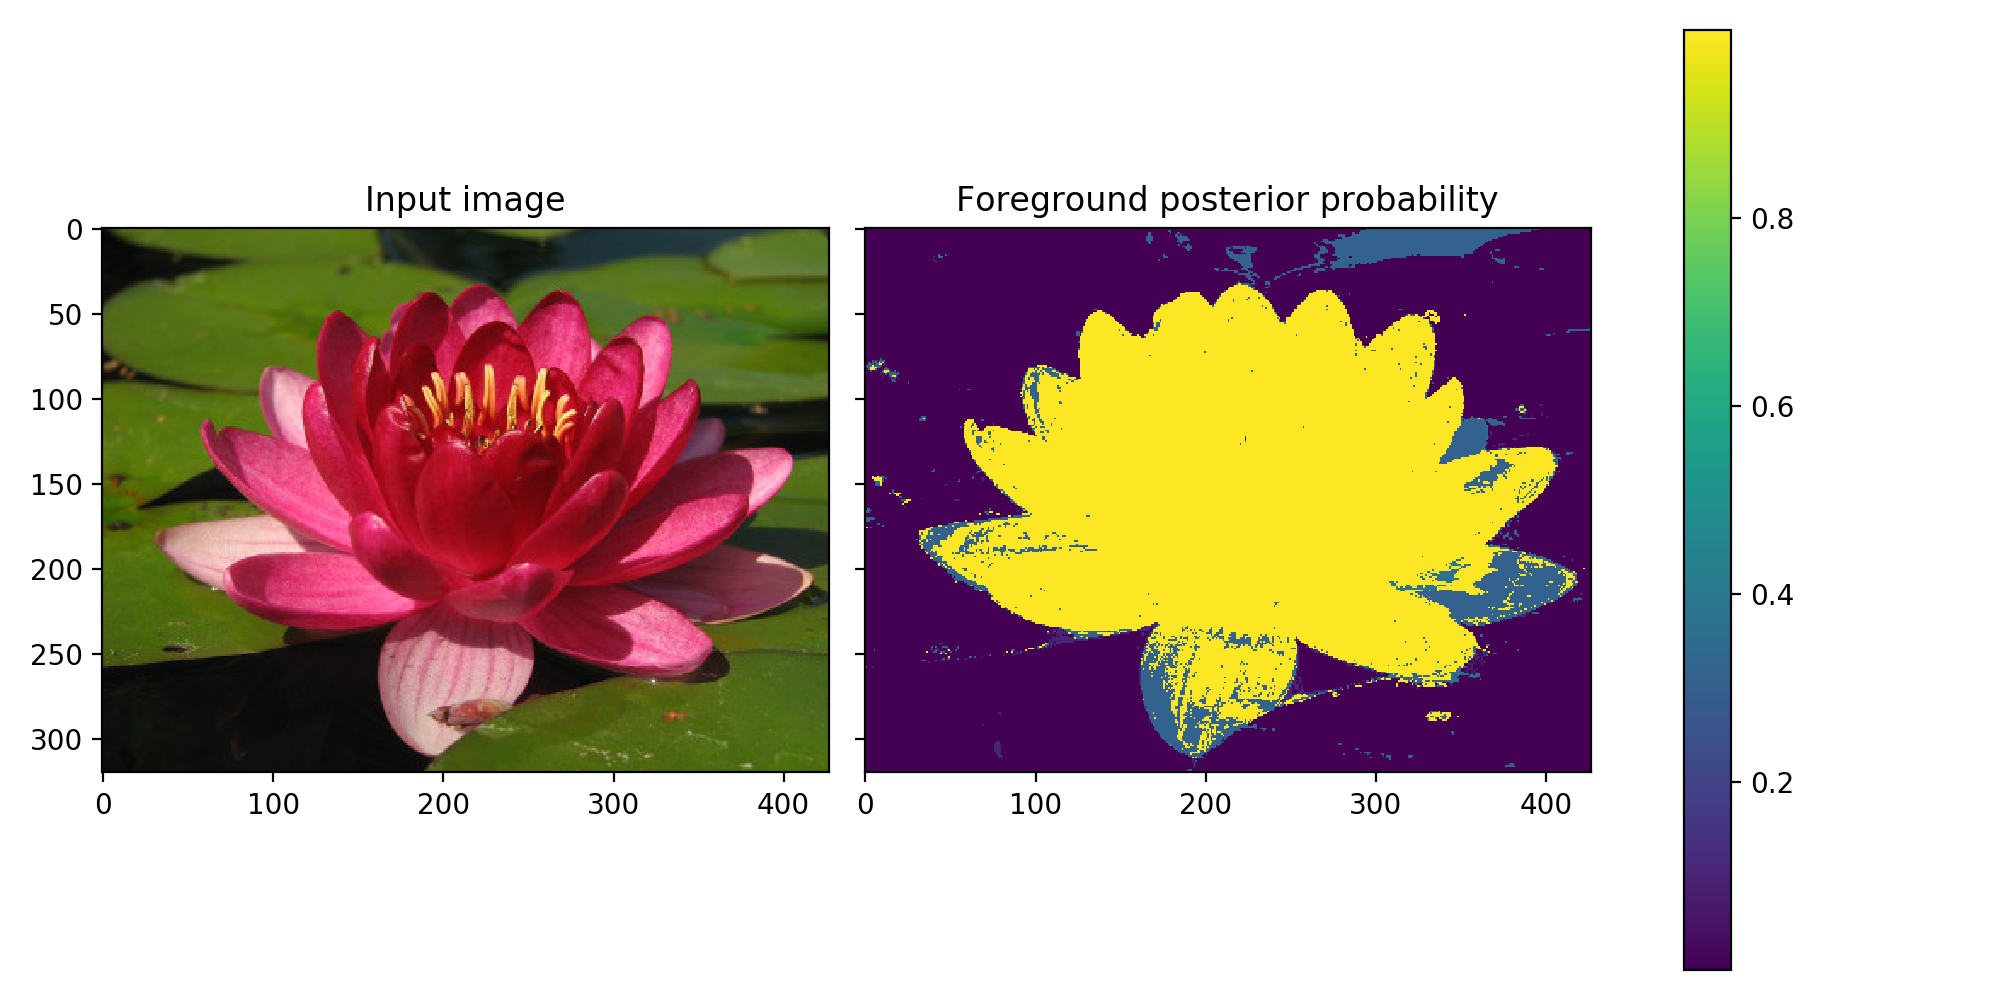

In [8]:
foreground_prob = foreground_pmap(im, fg_histogram, bg_histogram)
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
axes[0].imshow(im)
axes[0].set_title('Input image')
im_plot = axes[1].imshow(foreground_prob, cmap='viridis')
axes[1].set_title('Foreground posterior probability')
fig.tight_layout()
fig.colorbar(im_plot, ax=axes)
foreground_map = (foreground_prob > 0.5)

Explain what you see in the probability map.

## Unary potentials
Use the previously computed probability map `foreground_map` to compute the unary potential for both foreground and background.

This function `unary_potentials(probability_map, unary_weight)` shall use the `probability_map` and a scalar weighting factor to compute the unary potentials. It should return a matrix of the same size as the probability matrix.

<IPython.core.display.Javascript object>


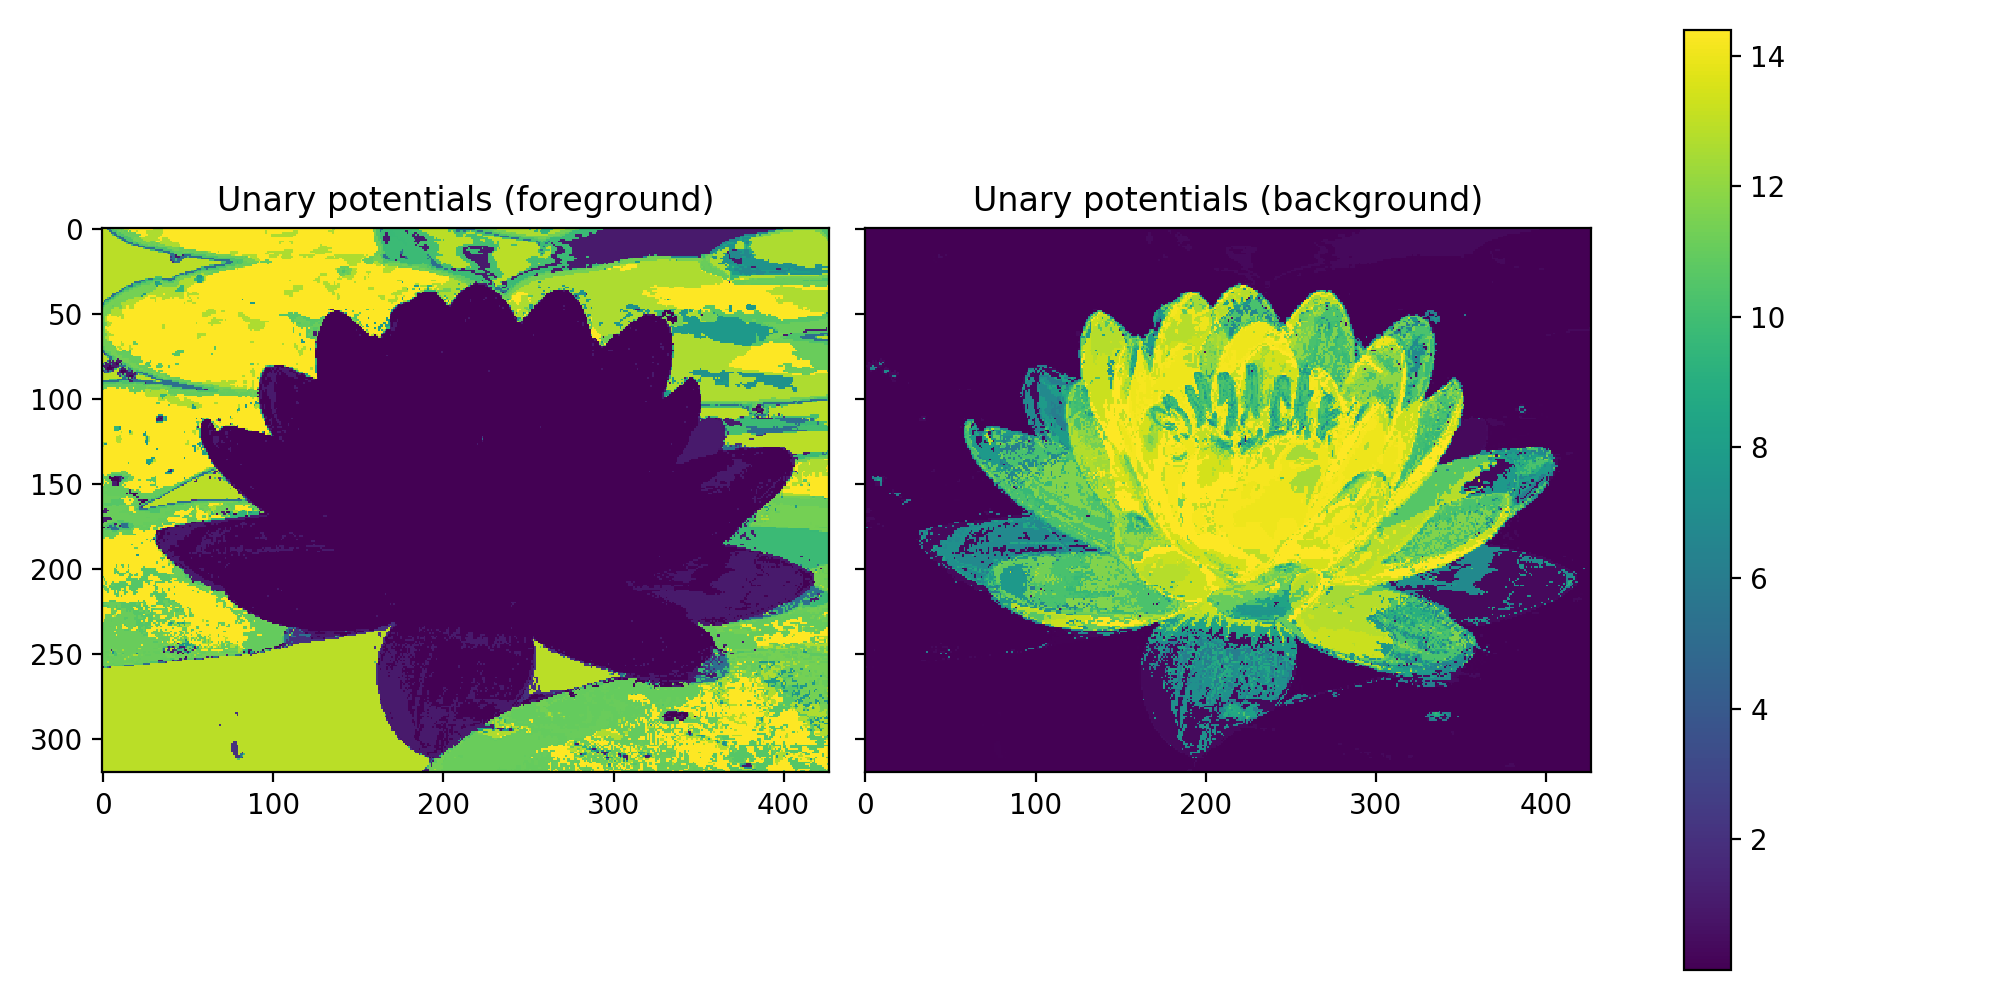

In [9]:
def unary_potentials(probability_map, unary_weight):
    ### BEGIN SOLUTION
    return -unary_weight * np.log(probability_map)
    ### END SOLUTION
    
unary_weight = 1
unary_fg = unary_potentials(foreground_prob, unary_weight)
unary_bg = unary_potentials(1 - foreground_prob, unary_weight)
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
axes[0].imshow(unary_fg)
axes[0].set_title('Unary potentials (foreground)')
im_plot = axes[1].imshow(unary_bg)
axes[1].set_title('Unary potentials (background)')
fig.tight_layout()
fig.colorbar(im_plot, ax=axes)

Why are the unary potentials for the foreground so small in the middle of the flower?

## Pairwise potentials

Create a function to compute the prefactor $w_p$ of the pairwise potential for two specific pixels. Implement the funtion below, where `img` is the image, `(x1, y1), (x2, y2)` are the pixel coordinates in the image and the last parameter is the weight $\omega_p$ for the pairwise potential. (Do not confuse `(x1, y1), (x2, y2)` with the $X_j, Y_j$ from the top of the page) 

Keep in mind that this prefactor does not depend on the labels and is therefore independent of $\mathcal{X}$.

Also, the function signature is more general (see the contrast-sensitive Potts Model question later on), not all parameters are needed here.

*Hint:* the function is extremely simple.

In [10]:
def pairwise_potential_prefactor(img, x1, y1, x2, y2, pairwise_weight):
    ### BEGIN SOLUTION
    return pairwise_weight * np.exp(-1e-1*np.sum((img[y1,x1]-img[y2,x2])**2))
    ### END SOLUTION

Using the functions from the previous task, implement a function to compute all the pairwise potentials for the image using 4-neighborhoods. That means only the top, bottom, left and right neighboring pixels should be connected to a given pixel.

The function `pairwise_potentials` should return the `edges` (represented as index pairs) and an array `costs` containing the corresponding edge costs (i.e. the value of the pairwise potential prefactor). Note that you have to use a linearized index instead of (x,y)-coordinates. A conversion function is supplied (`coords_to_index(x, y, width)`).

Again, `edges` should be an integer array of shape $k\times 2$, while `costs` should have length $k$, where $k$ is the number of neighborhood-edges in the image grid.

In [11]:
def coords_to_index(x, y, width):
    return y * width + x

def pairwise_potentials(im, pairwise_weight):
    ### BEGIN SOLUTION
    edges = []
    costs = []

    im = im.astype(np.float32)/255
    h, w = im.shape[:2]
    for y in range(h):
        for x in range(w):
            # Neighbor coordinates
            xs_neigh = x + np.array([0, 1, 0, -1])
            ys_neigh = y + np.array([-1, 0, 1, 0])
            
            # Make sure neighbors are within image
            mask = np.logical_and(
                np.logical_and(xs_neigh >= 0, xs_neigh < w),
                np.logical_and(ys_neigh >= 0, ys_neigh < h))
            xs_neigh = xs_neigh[mask]
            ys_neigh = ys_neigh[mask]
            
            center_index = coords_to_index(x, y, w)
            for x_neigh, y_neigh in zip(xs_neigh, ys_neigh):
                cost = pairwise_potential_prefactor(
                    im, x, y, x_neigh, y_neigh, pairwise_weight)
                neighbor_index = coords_to_index(x_neigh, y_neigh, w)
                edges.append((center_index, neighbor_index))
                costs.append(cost)
                
    edges = np.array(edges)
    costs = np.array(costs)
    ### END SOLUTION
    return edges, costs

pairwise_edges, pairwise_costs = pairwise_potentials(im, pairwise_weight=50)

Now you can execute the optimization and plot the resulting labeling.

In [12]:
def graph_cut(unary_fg, unary_bg, pairwise_edges, pairwise_costs):
    unaries = np.stack([unary_bg.flat, unary_fg.flat], axis=-1)
    labels = pygco.cut_general_graph(
        pairwise_edges, pairwise_costs, unaries, 
        1-np.eye(2), n_iter=-1, algorithm='swap')
    return labels.reshape(unary_fg.shape)

def graph_cut_slow(unary_fg, unary_bg, pairwise_edges, pairwise_costs):
    import networkx as nx
    from networkx.algorithms.flow import preflow_push
    
    graph = nx.Graph()
    s = object()
    t = object()
    
    edges = []
    for i, cost in enumerate(unary_bg.flat):
        edges.append((s, i, cost))
    for i, cost in enumerate(unary_fg.flat):
        edges.append((i, t, cost))
    for (i,j), cost in zip(pairwise_edges, pairwise_costs):
        edges.append((i, j, cost))
        
    graph.add_weighted_edges_from(edges, 'capacity')
    
    nodes_connected_to_s = nx.minimum_cut(
        graph, s, t, flow_func=preflow_push)[1][0]
    
    fg_pixel_indices = list(set(nodes_connected_to_s) - {s})
    labels = np.zeros_like(unary_fg, dtype=np.int)
    labels.flat[fg_pixel_indices] = 1
    return labels
    
graph_cut_result = graph_cut(unary_fg, unary_bg, pairwise_edges, pairwise_costs)
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)
axes[0].set_title('Simple thresholding of foreground probability')
axes[0].imshow(draw_mask_on_image(im, foreground_prob>0.5))
axes[1].set_title('Graph cut result')
axes[1].imshow(draw_mask_on_image(im, graph_cut_result))
fig.tight_layout()

AttributeError: module 'pygco' has no attribute 'cut_general_graph'

Why is the segmentation the way it is?

## [BONUS] Try another image

First, create a single function that runs the whole segmentation pipeline starting from the image.

`segment_image(...)` should return the final binary segmentation mask with 1 at the foreground pixels and 0 at the background.

In [ ]:
def segment_image(im, init_fg_mask, init_bg_mask,
                  unary_weight, pairwise_weight, n_bins):
    ### BEGIN SOLUTION
    fg_histogram = calculate_histogram(im, init_fg_mask, n_bins)
    bg_histogram = calculate_histogram(im, init_bg_mask, n_bins)

    foreground_prob = foreground_pmap(im, fg_histogram, bg_histogram)
    unary_fg = unary_potentials(foreground_prob, unary_weight)
    unary_bg = unary_potentials(1 - foreground_prob, unary_weight)
    
    pairwise_edges, pairwise_costs = pairwise_potentials(im, pairwise_weight)
    return graph_cut(unary_fg, unary_bg, pairwise_edges, pairwise_costs)
    ### END SOLUTION

In [ ]:
import skimage.data

def run_on_another_image():
    im = skimage.data.immunohistochemistry()
    #im = skimage.data.stereo_motorcycle()[0]
    h, w = im.shape[:2]
    fg_mask = np.zeros([h, w])
    bg_mask = np.zeros([h, w])

    # Set some appropriate parts of fg_mask and bg_mask to 1 for initialization.
    ### BEGIN SOLUTION
    # Immunohistochemistry image:
    fg_mask[0:125, 0:410] = 1
    bg_mask[306:512, 390:512] = 1
    # Flowers:
    #fg_mask[115:210, 75:375] = 1
    #bg_mask[:24] = 1
    ### END SOLUTION

    graph_cut_result = segment_image(
        im, fg_mask, bg_mask, 
        unary_weight=1, pairwise_weight=3, n_bins=8)
    
    fig, axes = plt.subplots(1, 3, figsize=(14,5), sharey=True)
    axes[0].set_title('Initial foreground mask')
    axes[0].imshow(draw_mask_on_image(im, fg_mask))
    axes[1].set_title('Initial background mask')
    axes[1].imshow(draw_mask_on_image(im, bg_mask))
    axes[2].set_title('Graph cut result')
    axes[2].imshow(draw_mask_on_image(im, graph_cut_result))
    fig.tight_layout()
    
run_on_another_image()

Does it look good? Which parameter would you need to change to reduce the number of holes in the segmentation? Try it.

Now try segmenting `im = skimage.data.stereo_motorcycle()[0]` using this technique. Can you segment out the motorbike by fiddling with the parameters? Why or why not?

## [BONUS] Contrast-Sensitive Potts Model
Go back to the `pairwise_potential_prefactor` function and modify it to incorporate a new term, resulting in the so-called *contrast sensitive Potts model*. The new pairwise potential should be:

$$
\psi_p (X_i,X_j,Y_i,Y_j,i,j)=\omega_p\cdot \exp\left(-\omega_d\|Y_i - Y_j\|^2\right)\cdot 
\begin{cases}
1,&\text{if } X_i \neq X_j \text{ and } i,j \text{ are neighbors}  \\
0,&\text{otherwise}
\end{cases}
$$

This means the prefactor is now $\omega_p\cdot \exp\left(-\omega_d\|Y_i - Y_j\|^2\right)$. For simplicity, you can hardcode the parameter $\omega_d$. 

What changes when using the contrast sensitive Potts model? What is the intuition behind adding this new term?

## [BONUS] Iterative Segmentation

We can make the result better if we iterate the labeling process several times. Implement `iterative_opt`, a method to execute the optimization process iteratively. 

Use the previously computed labeling as initial segmentation (instead of the rectangular masks we used above) and estimate new models (histograms and unaries) for foreground and background based on these. Solve the graph cut problem and use the resulting segmentation in the next iteration.

In [ ]:
def iterative_opt(img, fg_mask, n_bins, unary_weight,
                  pairwise_edges, pairwise_costs, n_iter):
    ### BEGIN SOLUTION
    h, w, c = img.shape
    for i in range(n_iter):
        # recalculate histograms based on new masks
        fg_histogram = calculate_histogram(img, fg_mask, n_bins)
        bg_histogram = calculate_histogram(img, 1-fg_mask, n_bins)

        foreground_probability = foreground_pmap(img, fg_histogram, bg_histogram)
        unary_fg = unary_potentials(foreground_probability, unary_weight)
        unary_bg = unary_potentials(1 - foreground_probability, unary_weight)
        fg_mask = graph_cut(unary_fg, unary_bg, pairwise_edges, pairwise_costs)
    return fg_mask
    ### END SOLUTION

labels_5 = iterative_opt(
    im, graph_cut_result, n_bins, unary_weight, pairwise_edges, pairwise_costs, n_iter=5)
labels_10 = iterative_opt(
    im, labels_5, n_bins, unary_weight, pairwise_edges, pairwise_costs, n_iter=5)

fig, axes = plt.subplots(1, 3, figsize=(12,4), sharex=True, sharey=True)
axes[0].set_title('Initial')
axes[0].imshow(draw_mask_on_image(im, graph_cut_result))
axes[1].set_title(f'After 5 iterations')
axes[1].imshow(draw_mask_on_image(im, labels_5))
axes[2].set_title(f'After 10 iterations')
axes[2].imshow(draw_mask_on_image(im, labels_10))
fig.tight_layout()

How did the labeling change? Do you have an explanation why?

## [BONUS++] Interactive Segmentation

We can get even better results by incorporating user input into the iterative segmentation process you implemented above.

Extend the given framework to allow the user to add or remove rectangular regions from the graph cut result. Then recalculate the foreground and background model according to new mask. Iterate this process until the user is satisfied with the result.

For this, look up how to create interactive graphical interfaces using Matplotlib, see for example `matplotlib.widgets.RectangleSelector` and `matplotlib.widgets.Button`.

In [ ]:
### BEGIN SOLUTION
import matplotlib.widgets

class InteractiveSegmenter:
    def __init__(self, im, mask, pairwise_weight):
        self.im = im
        self.mask = mask
        self.initial_mask = self.mask.copy()
        
        self.fig, self.ax = plt.subplots(1, figsize=(8,7), sharex=True, sharey=True)
        self.image_artist = self.ax.imshow(draw_mask_on_image(self.im, self.mask))

        self.buttons = [
            self.make_button('Reset', self.reset, 0.2),
            self.make_button('Add Box', lambda: self.set_mask_part(1), 0.35),
            self.make_button('Remove Box', lambda: self.set_mask_part(0), 0.5),
            self.make_button('Optimize!', self.optimize, 0.65)]
        
        self.selector = matplotlib.widgets.RectangleSelector(
            self.ax, None, drawtype='box', useblit=True, button=[1, 3],
            minspanx=5, minspany=5, spancoords='pixels', interactive=True)
        
        # Precompute these
        self.pairwise_edges, self.pairwise_costs = pairwise_potentials(self.im, pairwise_weight)
        self.n_bins = 10
        
    def make_button(self, text, func, pos):
        ax = self.fig.add_axes([pos, 0.05, 0.13, 0.055])
        button = matplotlib.widgets.Button(ax, text)
        button.on_clicked(lambda *args: func())
        return button
        
    def reset(self):
        self.mask[...] = self.initial_mask
        self.update_plot()
        
    def optimize(self):
        fg_histogram = calculate_histogram(self.im, self.mask, self.n_bins)
        bg_histogram = calculate_histogram(self.im, 1-self.mask, self.n_bins)
        foreground_prob = foreground_pmap(self.im, fg_histogram, bg_histogram)
        unary_fg = unary_potentials(foreground_prob, unary_weight)
        unary_bg = unary_potentials(1 - foreground_prob, unary_weight)
        self.mask = graph_cut(unary_fg, unary_bg, self.pairwise_edges, self.pairwise_costs)
        self.update_plot()

    def set_mask_part(self, value):
        [x1, x2, y1, y2] = np.array(self.selector.extents).astype(int)
        self.mask[y1:y2, x1:x2] = value
        self.update_plot()
        
    def update_plot(self):
        self.selector.extents = [0,0,0,0]
        self.image_artist.set_array(draw_mask_on_image(self.im, self.mask))
        for ar in self.selector.artists:
            ar.set_visible(False)

# Create an initial segmentation
# im = imageio.imread('toucan.jpg')
# h, w = im.shape[:2]
# init_fg_mask = np.zeros([h, w])
# init_bg_mask = np.zeros([h, w])
# init_fg_mask[128:188,128:395] = 1
# init_bg_mask[253:,:283] = 1

pairwise_weight = 3
graph_cut_result = segment_image(
    im, init_fg_mask, init_bg_mask,
    unary_weight=1, pairwise_weight=pairwise_weight, n_bins=10)

# Start interactive graphical interface
InteractiveSegmenter(im, graph_cut_result, pairwise_weight)
### END SOLUTION